# Análise de Correspondência Simples (ANACOR)

## GESTÃO
### Ao longo de 3 anos, foi aplicado um questionário com as seguintes afirmações: O quão satisfeito você está com a gestão do atual prefeito?
#### - As respostas foram registradas em uma escala Likert de 5 pontos.

#### O objetivo: há alguma variação na avaliação do prefeito ao longo dos anos?

##### Instalando os pacotes

In [1]:
! pip install pandas
! pip install numpy
! pip install scipy
! pip install plotly
! pip install seaborn
! pip install matplotlib
! pip install statsmodels
! pip install prince

#### Importando os pacotes necessários

In [2]:
import pandas as pd
import numpy as np
from scipy.stats import chi2_contingency
import statsmodels.api as sm
import seaborn as sns
import matplotlib.pyplot as plt
import prince
import plotly.io as pio
pio.renderers.default = 'browser'
import plotly.graph_objects as go

#### Análise de Correspondência Simples (ANACOR)

In [4]:
# Importando o banco de dados

gestao = pd.read_excel("gestao_municipal.xlsx")
# Fonte: Fávero e Belfiore (2024, Capítulo 11)

#### Informações descritivas sobre as variáveis

In [5]:
print(gestao['avaliacao'].value_counts())
print(gestao['ano'].value_counts())

avaliacao
Nem Concordo, Nem Discordo    2970
Concordo Parcialmente         2062
Discordo Parcialmente         2004
Discordo Totalmente            998
Concordo Totalmente            966
Name: count, dtype: int64
ano
20X1    3000
20X2    3000
20X3    3000
Name: count, dtype: int64


#### Criando a tabela de contingência

In [6]:
tabela = pd.crosstab(gestao["avaliacao"], gestao["ano"])

print(tabela)

# Nota: sempre manter o nome deste objeto como "tabela" para uso posterior!

ano                         20X1  20X2  20X3
avaliacao                                   
Concordo Parcialmente       1066   996     0
Concordo Totalmente          966     0     0
Discordo Parcialmente          1   998  1005
Discordo Totalmente            0     1   997
Nem Concordo, Nem Discordo   967  1005   998


#### Analisando a significância estatística da associação (teste qui²)

In [7]:
teste_qui2 = chi2_contingency(tabela)

print(f"estatística qui²: {round(teste_qui2[0], 2)}")
print(f"p-valor da estatística: {round(teste_qui2[1], 4)}")
print(f"graus de liberdade: {teste_qui2[2]}")

estatística qui²: 5956.44
p-valor da estatística: 0.0
graus de liberdade: 8


#### Mapa de calor dos resíduos padronizados ajustados

In [9]:
# Tabela de contingência

tab_cont = sm.stats.Table(tabela)

# Gráfico dos resíduos padronizados ajustados

fig = go.Figure()

maxz = np.max(tab_cont.standardized_resids)+0.1
minz = np.min(tab_cont.standardized_resids)-0.1

colorscale = ['lightgreen' if i>1.96 else '#FAF9F6' for i in np.arange(minz,maxz,0.01)]

fig.add_trace(
    go.Heatmap(
        x = tab_cont.standardized_resids.columns,
        y = tab_cont.standardized_resids.index,
        z = np.array(tab_cont.standardized_resids),
        text=tab_cont.standardized_resids.values,
        texttemplate='%{text:.2f}',
        showscale=False,
        colorscale=colorscale))

fig.update_layout(
    title='Resíduos Padronizados Ajustados',
    height = 600,
    width = 600)

fig.show()


#### Elaborando a ANACOR

In [10]:
# Na função, o input é a tabela de contingência criada antes!

ca = prince.CA().fit(tabela)

#### Obtendo os eigenvalues

In [11]:
tabela_autovalores = ca.eigenvalues_summary

print(tabela_autovalores)

# São gerados 'm' autovalores: m = mín(I-1,J-1)

          eigenvalue % of variance % of variance (cumulative)
component                                                    
0              0.503        75.96%                     75.96%
1              0.159        24.04%                    100.00%


#### Obtendo a inércia principal total

In [13]:
# Inércia principal total: É a soma dos eigenvalues (também é a divisão: estat. qui² / N)
# Quanto maior a inércia principal total, maior é a associação entre categorias

print(ca.total_inertia_)

0.6618261885878851


#### Obtendo as coordenadas do mapa perceptual

In [14]:
# Coordenadas da variável em linha
print(ca.row_coordinates(tabela))

# Coordenadas da variável em coluna
print(ca.column_coordinates(tabela))

                                   0         1
avaliacao                                     
Concordo Parcialmente      -0.634071 -0.315726
Concordo Totalmente        -1.222708  0.710623
Discordo Parcialmente       0.612588 -0.351081
Discordo Totalmente         1.225539  0.701462
Nem Concordo, Nem Discordo  0.012753 -0.010750
             0         1
ano                     
20X1 -0.866950  0.283437
20X2 -0.002882 -0.564066
20X3  0.869832  0.280629


#### Plotando o mapa percentual da Anacor

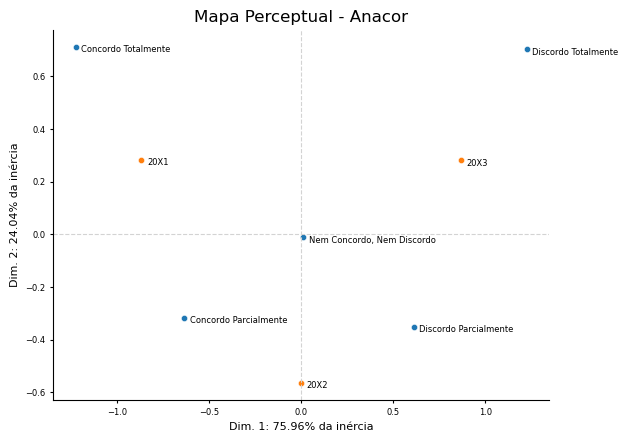

In [15]:
chart_df_row = pd.DataFrame({'var_row': tabela.index,
                             'x_row':ca.row_coordinates(tabela)[0].values,
                             'y_row': ca.row_coordinates(tabela)[1].values})

chart_df_col = pd.DataFrame({'var_col': tabela.columns,
                             'x_col':ca.column_coordinates(tabela)[0].values,
                             'y_col': ca.column_coordinates(tabela)[1].values})

def label_point(x, y, val, ax):
    a = pd.concat({'x': x, 'y': y, 'val': val}, axis=1)
    for i, point in a.iterrows():
        ax.text(point['x'] + 0.03, point['y'] - 0.02, point['val'], fontsize=6)

label_point(x = chart_df_col['x_col'],
            y = chart_df_col['y_col'],
            val = chart_df_col['var_col'],
            ax = plt.gca())

label_point(x = chart_df_row['x_row'],
            y = chart_df_row['y_row'],
            val = chart_df_row['var_row'],
            ax = plt.gca()) 

sns.scatterplot(data=chart_df_row, x='x_row', y='y_row', s=20)
sns.scatterplot(data=chart_df_col, x='x_col', y='y_col', s=20)
sns.despine(top=True, right=True, left=False, bottom=False)
plt.axhline(y=0, color='lightgrey', ls='--', linewidth=0.8)
plt.axvline(x=0, color='lightgrey', ls='--', linewidth=0.8)
plt.tick_params(size=2, labelsize=6)
plt.title("Mapa Perceptual - Anacor", fontsize=12)
plt.xlabel(f"Dim. 1: {tabela_autovalores.iloc[0,1]} da inércia", fontsize=8)
plt.ylabel(f"Dim. 2: {tabela_autovalores.iloc[1,1]} da inércia", fontsize=8)
plt.show()

#### Obtendo as coordenadas das observações

In [17]:
# Identificando as variáveis em linha e em coluna
coord_obs = gestao.rename(columns={'avaliacao':'var_row',
                                   'ano':'var_col'})

In [18]:
# Unindo as coordenadas das categorias ao DataFrame
coord_obs = pd.merge(coord_obs, chart_df_row, how='left', on='var_row')
coord_obs = pd.merge(coord_obs, chart_df_col, how='left', on='var_col')


In [19]:
# Calculando as coordenadas médias das observações (média de suas categorias)
coord_obs['x_obs'] = coord_obs[['x_row','x_col']].mean(axis=1)
coord_obs['y_obs'] = coord_obs[['y_row','y_col']].mean(axis=1)
print(coord_obs)

                         var_row var_col     x_row     y_row     x_col  \
0            Concordo Totalmente    20X1 -1.222708  0.710623 -0.866950   
1            Concordo Totalmente    20X1 -1.222708  0.710623 -0.866950   
2            Concordo Totalmente    20X1 -1.222708  0.710623 -0.866950   
3          Concordo Parcialmente    20X1 -0.634071 -0.315726 -0.866950   
4            Concordo Totalmente    20X1 -1.222708  0.710623 -0.866950   
...                          ...     ...       ...       ...       ...   
8995         Discordo Totalmente    20X3  1.225539  0.701462  0.869832   
8996       Discordo Parcialmente    20X3  0.612588 -0.351081  0.869832   
8997       Discordo Parcialmente    20X3  0.612588 -0.351081  0.869832   
8998       Discordo Parcialmente    20X3  0.612588 -0.351081  0.869832   
8999  Nem Concordo, Nem Discordo    20X3  0.012753 -0.010750  0.869832   

         y_col     x_obs     y_obs  
0     0.283437 -1.044829  0.497030  
1     0.283437 -1.044829  0.497030  


# FIM!